In [2]:
#Leg 1 245 256
#Leg 2 258 316
#Leg 3 320 327
#Leg 4 330 350
#Leg 5 353 405
#Leg 6 407 429
#Leg 7 432 443
#Leg 8 445 506
#Leg 9 509 521
#Leg 10 523 531
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import cartopy.crs as crs
import matplotlib.ticker as mticker
from netCDF4 import Dataset
import netCDF4
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import h5py as h5
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from mpl_toolkits.axes_grid1 import make_axes_locatable
from wrf import getvar, interplevel, to_np, get_basemap, latlon_coords,latlon_coords, smooth2d,get_cartopy, cartopy_xlim, cartopy_ylim
import pandas as pd
import csv

In [3]:
def wrf_pres(P,PB):
    return (P+PB) #in Pa

def wrf_height(PH,PHB):
    return (PH+PHB)/9.81

def wrf_theta(PTEMP):
    return (PTEMP+300.)

def wrf_temp(THETA,PRES):
    return (THETA)*(PRES/1000.)**(.2854) # in hPa
def es(T):
    return (610.7*np.exp(((2500800+(4218-1870.4)*273.16)*(1/273.16-1/T)-(4218-1870.4)*np.log(T/273.16))/461.51))

In [4]:
filename = "wrfout_d01_2017-01-08_02:50:00"
picname = "numbercon_" + filename[19:27] + ".png"
print(picname)
ncfile2 = Dataset(filename)
ncfile = h5.File(filename, 'r')
ds = netCDF4.Dataset(filename)

numbercon_08_02:50.png


In [5]:
cloud_number = ncfile['QNCLOUD'][:].squeeze()
rain_number = ncfile['QNRAIN'][:].squeeze()
ice_number = ncfile['QNICE'][:].squeeze()
wateraero_number = ncfile['QNWFA'][:].squeeze() #kg-
iceaero_number = ncfile['QNIFA'][:].squeeze()
ter = getvar(ncfile2, "ter", units = 'm', meta= False)
P = ncfile['P'][:].squeeze()
PB = ncfile['PB'][:].squeeze()
PHB = ncfile['PHB'][:].squeeze()
PH = ncfile['PH'][:].squeeze()
lat = ncfile['XLAT'][:].squeeze()
lon = ncfile['XLONG'][:].squeeze()
PRES = wrf_pres(P,PB)/100
tv = getvar(ncfile2, 'tv', units = 'K', meta = False)

THETA = ncfile['T'][:]
THETA = wrf_theta(THETA)
TEMP = wrf_temp(THETA,PRES).squeeze()
TEMP= TEMP - 273.16

In [6]:
PRES = PRES*100
Density = PRES/(287.056*tv)
PRES = PRES/100
print(Density[0:80,325,400])

[1.0265096426010132 1.0242079496383667 1.0219769477844238 1.01975679397583
 1.0176547765731812 1.015512228012085 1.0133668184280396 1.011142373085022
 1.0087908506393433 1.0063128471374512 1.003554105758667
 1.0005494356155396 0.99720698595047 0.9934092164039612 0.9891601204872131
 0.9843431711196899 0.9788740277290344 0.9724770188331604
 0.9651756286621094 0.9570748805999756 0.9482505917549133
 0.938834011554718 0.9290258288383484 0.919413685798645 0.9104858636856079
 0.9020234942436218 0.8940058350563049 0.8863599300384521
 0.8789733648300171 0.8718321919441223 0.864982545375824
 0.8583479523658752 0.8519099950790405 0.8455780744552612
 0.8393374085426331 0.8331996202468872 0.8271210789680481
 0.821065366268158 0.8150774240493774 0.8091719150543213
 0.8033216595649719 0.79754239320755 0.7918488383293152 0.7859336137771606
 0.7796075344085693 0.7728863954544067 0.7656683325767517
 0.7577019333839417 0.7481521964073181 0.7374982833862305
 0.726768434047699 0.71597820520401 0.7044981122

In [7]:
cloud_number = cloud_number * Density / 1000000
rain_number = rain_number * Density # m^-3
iceaero_number = iceaero_number * Density / 1000000
wateraero_number = wateraero_number * Density / 1000000
ice_number = ice_number * Density / 1000 # per liter

In [8]:
from wrf import (to_np, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords, CoordPair, vertcross, interpline)

ys =[    0. ,       199.45068 ,  398.90137,   598.35205,   797.80273,   1000,
  1196.7041,   1396.1548,   1595.6055 ,  1795.0562 ,  2000,   2193.9575,
  2393.4082,   2592.859,    2792.3096,   3000,   3191.211,    3390.6616,
  3590.1123,   3789.563 ,   4000,  4188.4644,   4387.915,    4587.3657,
  4786.8164 ,  5000 ,   5185.718 ,   5385.1685  , 5584.619,    5784.07,
  6000,   6182.971 ,   6382.422 ,   6581.8726 ,  6781.323 ,   7000]   #7379.6753  , 7579.126,    7778.5767 ,  7978.0273,   8177.478,
  #8376.929  ,  8576.379 ,   8775.83 ,    8975.281 ,   9174.731  ,  9374.182,
  #9573.633,    9773.084 ,   9972.534 ,  10171.984 ,  10371.436,   10570.887,
 #10770.337,   10969.787  , 11169.238,   11368.689,   11568.14,    11767.59,
 #11967.041,   12166.492,   12365.942,   12565.393,   12764.844,   12964.295,
 #13163.745,   13363.195,   13562.646,   13762.098,   13961.548,   14160.998,
# 14360.449,   14559.9,     14759.351,   14958.801,   15158.252,   15357.703,
 #15557.153,   15756.604,   15956.055 ,  16155.506 ,  16354.956,   16554.406,
 #16753.857,   16953.309,   17152.758,   17352.209 ,  17551.66  ,  17751.111,
 #17950.562 ,  18150.012  , 18349.463  , 18548.914,   18748.363 ,  18947.814,
 #19147.266,   19346.717,   19546.168,   19745.617  ]
coord_pairs = np.array([CoordPair(x=359.0, y=326.0, lat=44.20601272583008, lon=-116.52633666992188),
 CoordPair(x=360.0, y=325.9895833333333, lat=44.20607376098633, lon=-116.5150146484375),
 CoordPair(x=361.0, y=325.9791666666667, lat=44.20615005493164, lon=-116.5036849975586),
 CoordPair(x=362.0, y=325.96875, lat=44.206199645996094, lon=-116.49236297607422),
 CoordPair(x=363.0, y=325.9583333333333, lat=44.20626449584961, lon=-116.48104095458984),
 CoordPair(x=364.0, y=325.9479166666667, lat=44.20632553100586, lon=-116.46971893310547),
 CoordPair(x=365.0, y=325.9375, lat=44.20638656616211, lon=-116.45838928222656),
 CoordPair(x=366.0, y=325.9270833333333, lat=44.20644760131836, lon=-116.44708251953125),
 CoordPair(x=367.0, y=325.9166666666667, lat=44.20650100708008, lon=-116.43576049804688),
 CoordPair(x=368.0, y=325.90625, lat=44.20655822753906, lon=-116.42444610595703),
 CoordPair(x=369.0, y=325.8958333333333, lat=44.20661163330078, lon=-116.41312408447266),
 CoordPair(x=370.0, y=325.8854166666667, lat=44.206661224365234, lon=-116.40180206298828),
 CoordPair(x=371.0, y=325.875, lat=44.206722259521484, lon=-116.3904800415039),
 CoordPair(x=372.0, y=325.8645833333333, lat=44.2067756652832, lon=-116.37915802001953),
 CoordPair(x=373.0, y=325.8541666666667, lat=44.20682144165039, lon=-116.36782836914062),
 CoordPair(x=374.0, y=325.84375, lat=44.206871032714844, lon=-116.35650634765625),
 CoordPair(x=375.0, y=325.8333333333333, lat=44.20691680908203, lon=-116.34518432617188),
 CoordPair(x=376.0, y=325.8229166666667, lat=44.20697021484375, lon=-116.33387756347656),
 CoordPair(x=377.0, y=325.8125, lat=44.207008361816406, lon=-116.32255554199219),
 CoordPair(x=378.0, y=325.8020833333333, lat=44.20705795288086, lon=-116.31123352050781),
 CoordPair(x=379.0, y=325.7916666666667, lat=44.20710372924805, lon=-116.29991912841797),
 CoordPair(x=380.0, y=325.78125, lat=44.20714569091797, lon=-116.2885971069336),
 CoordPair(x=381.0, y=325.7708333333333, lat=44.20719528198242, lon=-116.27726745605469),
 CoordPair(x=382.0, y=325.7604166666667, lat=44.20722961425781, lon=-116.26594543457031),
 CoordPair(x=383.0, y=325.75, lat=44.207271575927734, lon=-116.25462341308594),
 CoordPair(x=384.0, y=325.7395833333333, lat=44.207305908203125, lon=-116.24330139160156),
 CoordPair(x=385.0, y=325.7291666666667, lat=44.20734405517578, lon=-116.23197937011719),
 CoordPair(x=386.0, y=325.71875, lat=44.20738220214844, lon=-116.22065734863281),
 CoordPair(x=387.0, y=325.7083333333333, lat=44.20741653442383, lon=-116.20933532714844),
 CoordPair(x=388.0, y=325.6979166666667, lat=44.20744705200195, lon=-116.19801330566406),
 CoordPair(x=389.0, y=325.6875, lat=44.207481384277344, lon=-116.18669128417969),
 CoordPair(x=390.0, y=325.6770833333333, lat=44.20751190185547, lon=-116.17537689208984),
 CoordPair(x=391.0, y=325.6666666666667, lat=44.207542419433594, lon=-116.16405487060547),
 CoordPair(x=392.0, y=325.65625, lat=44.20757293701172, lon=-116.15272521972656),
 CoordPair(x=393.0, y=325.6458333333333, lat=44.20759963989258, lon=-116.14141082763672),
 CoordPair(x=394.0, y=325.6354166666667, lat=44.2076301574707, lon=-116.13009643554688),
 CoordPair(x=395.0, y=325.625, lat=44.20765686035156, lon=-116.1187744140625),
 CoordPair(x=396.0, y=325.6145833333333, lat=44.207679748535156, lon=-116.10745239257812),
 CoordPair(x=397.0, y=325.6041666666667, lat=44.20770263671875, lon=-116.09613037109375),
 CoordPair(x=398.0, y=325.59375, lat=44.207725524902344, lon=-116.08480834960938),
 CoordPair(x=399.0, y=325.5833333333333, lat=44.207740783691406, lon=-116.073486328125),
 CoordPair(x=400.0, y=325.5729166666667, lat=44.20777130126953, lon=-116.0621566772461),
 CoordPair(x=401.0, y=325.5625, lat=44.20778274536133, lon=-116.05083465576172),
 CoordPair(x=402.0, y=325.5520833333333, lat=44.20780563354492, lon=-116.03952026367188),
 CoordPair(x=403.0, y=325.5416666666667, lat=44.207820892333984, lon=-116.0281982421875),
 CoordPair(x=404.0, y=325.53125, lat=44.20783996582031, lon=-116.01687622070312),
 CoordPair(x=405.0, y=325.5208333333333, lat=44.20785903930664, lon=-116.00555419921875),
 CoordPair(x=406.0, y=325.5104166666667, lat=44.20787048339844, lon=-115.99423217773438),
 CoordPair(x=407.0, y=325.5, lat=44.2078857421875, lon=-115.98291015625),
 CoordPair(x=408.0, y=325.4895833333333, lat=44.2078971862793, lon=-115.97158813476562),
 CoordPair(x=409.0, y=325.4791666666667, lat=44.207908630371094, lon=-115.96027374267578),
 CoordPair(x=410.0, y=325.46875, lat=44.207908630371094, lon=-115.94894409179688),
 CoordPair(x=411.0, y=325.4583333333333, lat=44.207923889160156, lon=-115.9376220703125),
 CoordPair(x=412.0, y=325.4479166666667, lat=44.20792770385742, lon=-115.92630004882812),
 CoordPair(x=413.0, y=325.4375, lat=44.20793533325195, lon=-115.91498565673828),
 CoordPair(x=414.0, y=325.4270833333333, lat=44.207942962646484, lon=-115.9036636352539),
 CoordPair(x=415.0, y=325.4166666666667, lat=44.207942962646484, lon=-115.89234161376953),
 CoordPair(x=416.0, y=325.40625, lat=44.20794677734375, lon=-115.88102722167969),
 CoordPair(x=417.0, y=325.3958333333333, lat=44.20794677734375, lon=-115.86970520019531),
 CoordPair(x=418.0, y=325.3854166666667, lat=44.207950592041016, lon=-115.85838317871094),
 CoordPair(x=419.0, y=325.375, lat=44.207942962646484, lon=-115.84706115722656),
 CoordPair(x=420.0, y=325.3645833333333, lat=44.20794677734375, lon=-115.83573913574219),
 CoordPair(x=421.0, y=325.3541666666667, lat=44.20794677734375, lon=-115.82441711425781),
 CoordPair(x=422.0, y=325.34375, lat=44.20793533325195, lon=-115.81309509277344),
 CoordPair(x=423.0, y=325.3333333333333, lat=44.20793533325195, lon=-115.80176544189453),
 CoordPair(x=424.0, y=325.3229166666667, lat=44.207923889160156, lon=-115.79044342041016),
 CoordPair(x=425.0, y=325.3125, lat=44.20792007446289, lon=-115.77912139892578),
 CoordPair(x=426.0, y=325.3020833333333, lat=44.20791244506836, lon=-115.76780700683594),
 CoordPair(x=427.0, y=325.2916666666667, lat=44.20790481567383, lon=-115.75648498535156),
 CoordPair(x=428.0, y=325.28125, lat=44.20789337158203, lon=-115.74516296386719),
 CoordPair(x=429.0, y=325.2708333333333, lat=44.207881927490234, lon=-115.73384857177734),
 CoordPair(x=430.0, y=325.2604166666667, lat=44.20787048339844, lon=-115.72252655029297),
 CoordPair(x=431.0, y=325.25, lat=44.20785903930664, lon=-115.7112045288086),
 CoordPair(x=432.0, y=325.2395833333333, lat=44.20783996582031, lon=-115.69988250732422),
 CoordPair(x=433.0, y=325.2291666666667, lat=44.20782470703125, lon=-115.68856048583984),
 CoordPair(x=434.0, y=325.21875, lat=44.207801818847656, lon=-115.67723846435547),
 CoordPair(x=435.0, y=325.2083333333333, lat=44.20779037475586, lon=-115.66590881347656),
 CoordPair(x=436.0, y=325.1979166666667, lat=44.207763671875, lon=-115.65458679199219),
 CoordPair(x=437.0, y=325.1875, lat=44.2077522277832, lon=-115.64326477050781),
 CoordPair(x=438.0, y=325.1770833333333, lat=44.20772933959961, lon=-115.63194274902344),
 CoordPair(x=439.0, y=325.1666666666667, lat=44.207706451416016, lon=-115.62062072753906),
 CoordPair(x=440.0, y=325.15625, lat=44.207679748535156, lon=-115.60929870605469),
 CoordPair(x=441.0, y=325.1458333333333, lat=44.2076530456543, lon=-115.59798431396484),
 CoordPair(x=442.0, y=325.1354166666667, lat=44.20762634277344, lon=-115.58666229248047),
 CoordPair(x=443.0, y=325.125, lat=44.20759582519531, lon=-115.5753402709961),
 CoordPair(x=444.0, y=325.1145833333333, lat=44.20757293701172, lon=-115.56401824951172),
 CoordPair(x=445.0, y=325.1041666666667, lat=44.20754623413086, lon=-115.5527114868164),
 CoordPair(x=446.0, y=325.09375, lat=44.2075080871582, lon=-115.54138946533203),
 CoordPair(x=447.0, y=325.0833333333333, lat=44.207481384277344, lon=-115.53006744384766),
 CoordPair(x=448.0, y=325.0729166666667, lat=44.20745086669922, lon=-115.51874542236328),
 CoordPair(x=449.0, y=325.0625, lat=44.20741653442383, lon=-115.50741577148438),
 CoordPair(x=450.0, y=325.0520833333333, lat=44.20738220214844, lon=-115.49609375),
 CoordPair(x=451.0, y=325.0416666666667, lat=44.207340240478516, lon=-115.48477172851562),
 CoordPair(x=452.0, y=325.03125, lat=44.207305908203125, lon=-115.47344970703125),
 CoordPair(x=453.0, y=325.0208333333333, lat=44.20726013183594, lon=-115.46212768554688),
 CoordPair(x=454.0, y=325.0104166666667, lat=44.20722198486328, lon=-115.4508056640625),
 CoordPair(x=455.0, y=325.0, lat=44.20718765258789, lon=-115.43948364257812)])

/glade/u/ssg/ch/usr/jupyterhub/envs/npl-3.7.9/dav/lib/python3.7/site-packages/ipykernel_launcher.py:52: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

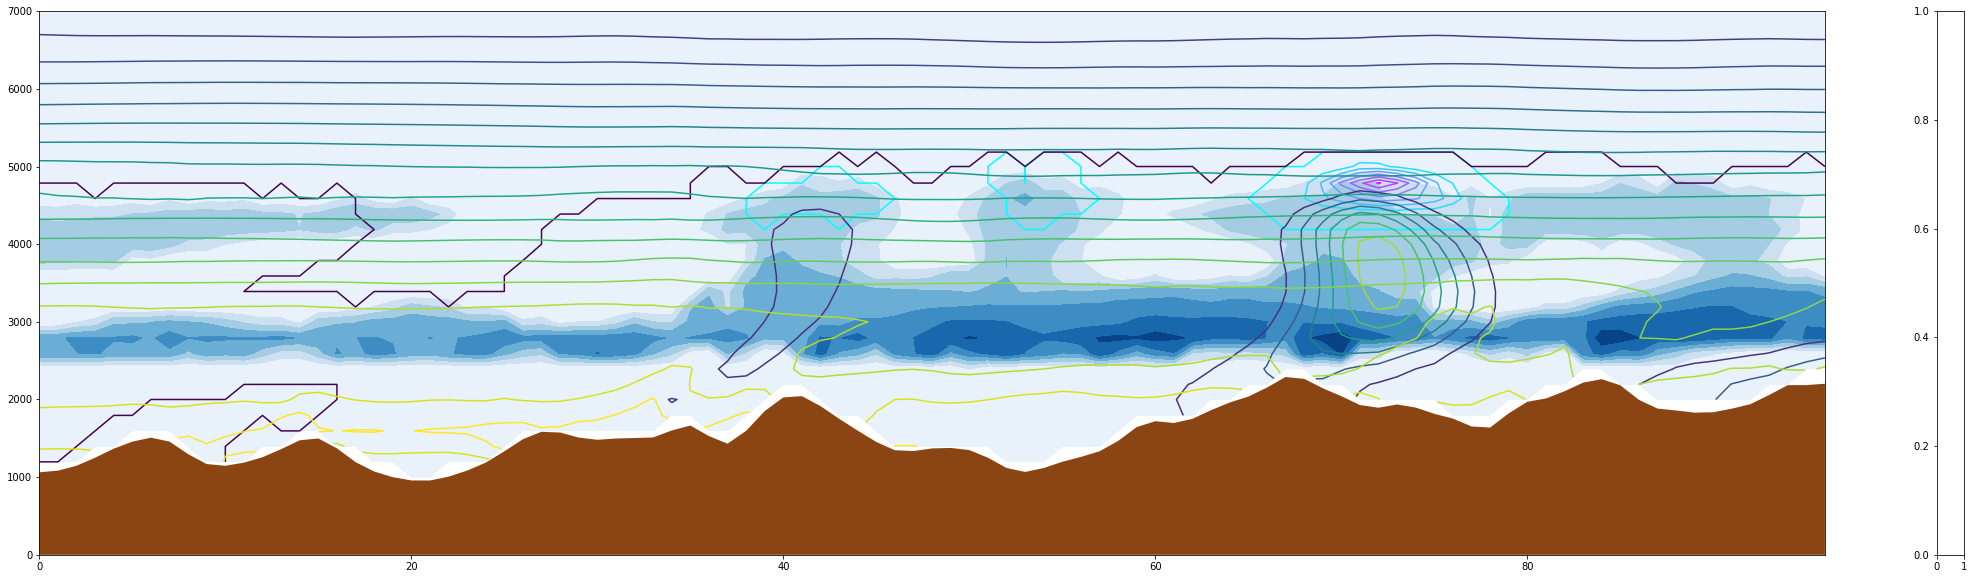

In [21]:
x_ticks = np.arange(coord_pairs.shape[0])
x_labels = [pair.latlon_str() for pair in to_np(coord_pairs)]
xlabsnew = []
for u in x_labels:
    xlabs = u[0:5]+","+u[9:16]
    xlabsnew.append(xlabs)
z = getvar(ds, "z")
ter = getvar(ds, "ter")
cloud = ncfile['QCLOUD'][:].squeeze()* 1000
start_point = CoordPair(lat=44.207, lon=-116.525)
end_point = CoordPair(lat=44.206, lon=-115.438)
tntr = -16
tint = 2
tmin = -36
tmax = -0
cntr = .45
cint = .01
cmin = .05
cmax = .90
imin = .0000002
imax = .0000028
iin =  .0000002

Lmin = 5
Lmax = 72
Lint = 1
levs = np.arange(Lmin,Lmax,Lint)

clevs = np.arange(cmin, cmax, cint)
tevs = np.arange(tmin, tmax, tint)
ievs = np.arange(imin, imax, iin)
cloudnumber_cross = vertcross(cloud_number, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
icenumber_cross = vertcross(ice_number, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
rainnumber_cross = vertcross(rain_number, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
cloud_cross = vertcross(cloud, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
temp_cross = vertcross(TEMP, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
iceaero_cross = vertcross(iceaero_number, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
wateraero_cross = vertcross(wateraero_number, z, wrfin=ds, start_point=start_point,
                       end_point=end_point,latlon=True, meta=True)[0:36,:]
ter_line = interpline(ter, wrfin=ds, start_point=start_point,
                      end_point=end_point)

xs = np.arange(0, cloud_cross.shape[-1], 1)
fig = plt.figure(figsize=(40,10))
ax = plt.axes()
ax_cross = plt.axes()
#cloud_contours = ax.contourf(xs, ys, to_np(cloud_cross), clevs, cmap=get_cmap("Blues"))
cloudnumber_contours = ax.contourf(xs, ys, to_np(cloudnumber_cross), cmap=get_cmap("Blues"))#
ice_contours = ax.contour(xs, ys, to_np(icenumber_cross), cmap = get_cmap("cool")) #cmap = get_cmap("RdPu"))
rain_contours = ax.contour(xs, ys, to_np(rainnumber_cross))
#snow_contours = ax.contour(xs, ys, to_np(snow_cross), cmap = "cool")
#graup_contours = ax.contour(xs, ys, to_np(graup_cross), cmap="autumn")
temp_contours = ax.contour(xs,ys, to_np(temp_cross), tevs)
xs = np.arange(0, 97, 1)
ht_fill = ax_cross.fill_between( xs, to_np(ter_line),
                                facecolor="saddlebrown")

#cbr1=plt.colorbar(cloud_contours, ax=ax)
#cbr1.set_label('Cloud Mixing ratio (g/Kg)', fontsize = 10, labelpad = 15)
#cbr2=plt.colorbar(ice_contours, ax=ax)
#cbr2.set_label('Ice Number Concentration ($L^-1$)', fontsize = 20, labelpad = 15)
#cbr3=plt.colorbar(rain_contours, ax=ax)
#cbr3.set_label('Rain Number Concentration ($m^-3$)', fontsize = 20, labelpad = 15)5
#cbr4=plt.colorbar(cloudnumber_contours, ax=ax)
#cbr4.set_label('Cloud Number Concentration ($cm^-3$)', fontsize = 20, labelpad = 15)
#cbr4=plt.colorbar(graup_contours, ax=ax)
#cbr4.set_label('Graupel Mixing ratio (g/Kg)', fontsize = 10, labelpad = 15)
#cbr2=plt.colorbar(rain_contours, ax=ax)
#cbr3=plt.colorbar(ice_contours, ax=ax)
#cbr4=plt.colorbar(snow_contours, ax=ax)
#cbr5=plt.colorbar(graup_contours, ax=ax)
vert_vals = [0,199.45068,  398.90137,  598.35205,  797.80273,  1000,
 1196.7041,  1396.1548,  1595.6055,  1795.0562,  2000,  2193.9575,
 2393.4082,  2592.859,   2792.3096,  3000,  3191.211,   3390.6616,
 3590.1123,  3789.563,   4000,  4188.4644,  4387.915,   4587.3657,
 4786.8164,  5000,   5185.718,   5385.1685,  5584.619,   5784.07,
 6000,  6182.971,   6382.422,   6581.8726,  6781.323,   7000,
 7180.2246,  7379.6753,  7579.126]
vert_vals = np.array(vert_vals)
v_ticks = np.arange(vert_vals.shape[0]-2)
ax.set_yticks(ys[::5])
ax.set_yticklabels(ys[::5], fontsize=8)
cbr3.ax.tick_params(labelsize=16)
cbr2.ax.tick_params(labelsize=16)
cbr4.ax.tick_params(labelsize=16) 
plt.ylabel("Height (m)", fontsize = 23)
plt.xticks(fontsize=40)
plt.yticks(fontsize=17)
plt.clabel(temp_contours, inline = 1, fontsize = 10, fmt = '%i')
#plt.xlabel("Cloud Mixing ratio (Kg/Kg^-1)")
num_ticks = 5
thin = int((len(x_ticks) / num_ticks) + .5)
ax_cross.set_xticks(x_ticks[::thin])
ax_cross.set_xticklabels(xlabsnew[::thin], rotation=20, fontsize=18)

#plt.clabel(rain_contours, inline = 1, fontsize = 7,fmt='%i')
fig.set_size_inches(30, 9)
fig.show()
fig.savefig(picname, dpi = 100)

In [44]:
#250
#300
#345